GPU Server Specs

In [42]:
!nvidia-smi

Fri Nov 24 23:24:26 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti      On | 00000000:09:00.0 Off |                  N/A |
| 27%   25C    P8               20W / 250W|  11003MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
sns.set(color_codes=True)

from transformers import BertTokenizer,BertForSequenceClassification,AdamW

In [3]:
file_paths = ['data/goemotions_1.csv', 'data/goemotions_2.csv', 'data/goemotions_3.csv']

df_list = [pd.read_csv(file) for file in file_paths]
df = pd.concat(df_list, ignore_index=True)

emotion_labels = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 
                  'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 
                  'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 
                  'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 
                  'relief', 'remorse', 'sadness', 'surprise', 'neutral']
df = df[['text'] + emotion_labels]

Dataset Size

In [18]:
print(f'Number of Reddit Samples: ',len(df))

Number of Reddit Samples:  211225


In [4]:
df.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
import re

hashtags = re.compile(r"^#\S+|\s#\S+")
mentions = re.compile(r"^@\S+|\s@\S+")
urls = re.compile(r"https?://\S+")

def process_text(text):
    text = re.sub(r'http\S+', '', text)
    text = hashtags.sub(' hashtag', text)
    text = mentions.sub(' entity', text)
    return text.strip().lower()

df['text'] = df.text.apply(process_text)

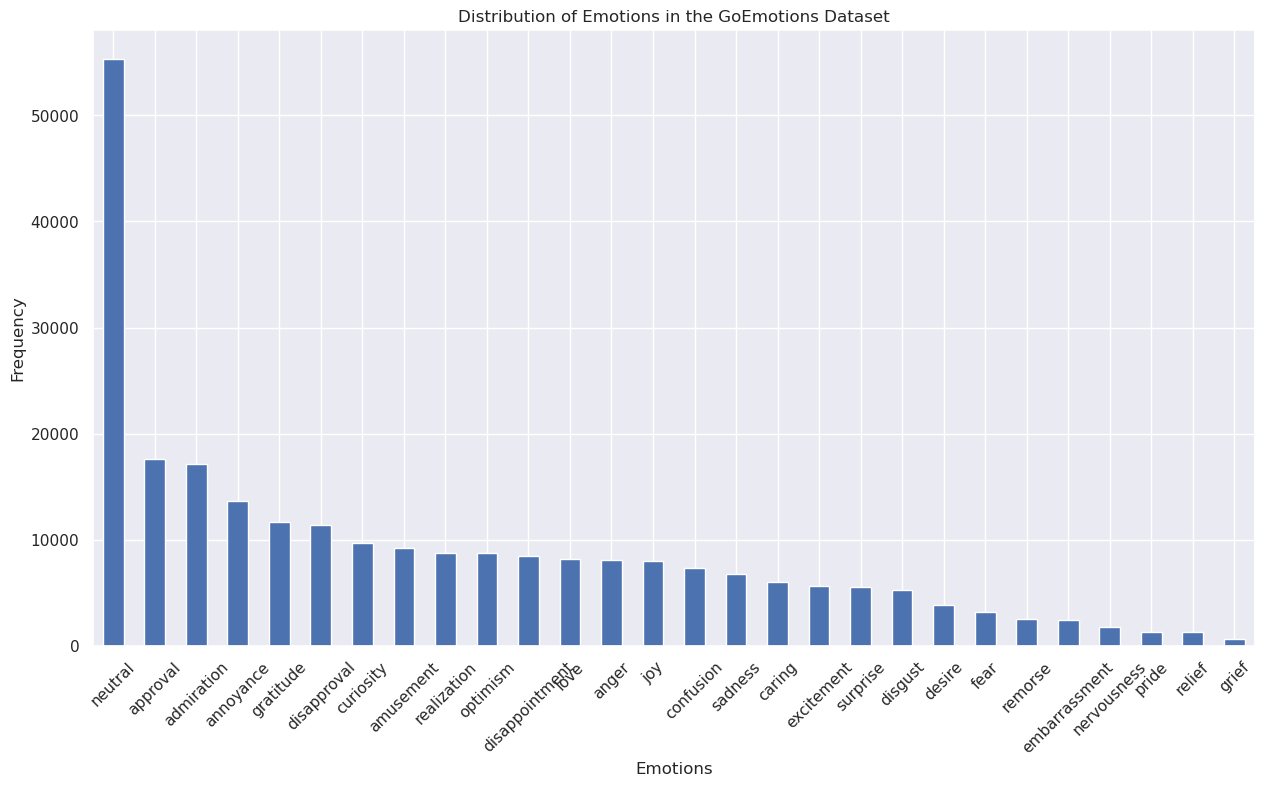

In [6]:
emotion_counts = df[emotion_labels].sum()
sorted_emotion_counts = emotion_counts.sort_values(ascending=False)

plt.figure(figsize=(15, 8))
sorted_emotion_counts.plot(kind='bar')
plt.title('Distribution of Emotions in the GoEmotions Dataset')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [8]:
df[emotion_labels].values

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Tokenization and Input Formatting

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
labels = df[emotion_labels].values
texts = df.text.values

input_ids = []
attention_masks = []

for text in texts:
    encoded_data = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_data['input_ids'])
    attention_masks.append(encoded_data['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/19aag9/ENTER/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler,TensorDataset,random_split
from transformers import get_linear_schedule_with_warmup

In [31]:
# Create train-validation split
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
print('Training Size - ',train_size)
print('Validation Size - ',val_size)

Training Size -  168980
Validation Size -  42245


In [32]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(emotion_labels),
    output_attentions=False,
    output_hidden_states=False
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [34]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
device

device(type='cuda')

In [35]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix

In [39]:
def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        
        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        print("Input IDs shape:", inputs['input_ids'].shape)  # Should be [batch_size, seq_length]
        print("Attention Mask shape:", inputs['attention_mask'].shape)  # Should be [batch_size, seq_length]
        print("Labels shape:", inputs['labels'].shape)  # Should be [batch_size, num_labels]
        print("Logits shape:", logits.shape)  # Should be [batch_size, num_labels]

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [44]:
torch.cuda.empty_cache()


In [45]:
from tqdm.notebook import tqdm
# Loss function for multi-label classification
loss_function = nn.BCEWithLogitsLoss()

for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0

    progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()

        # Ensure batch data is on the same device as the model
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Compute loss
        loss = loss_function(logits, labels.float())  # Convert labels to float to match logits
        loss_train_total += loss.item()

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total/len(train_dataloader)            
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_labels = evaluate(validation_dataloader)
    val_f1 = f1_score(true_labels, np.round(predictions), average='micro')
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Micro): {val_f1}')


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/5281 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 MiB. GPU 0 has a total capacty of 10.75 GiB of which 7.62 MiB is free. Including non-PyTorch memory, this process has 10.74 GiB memory in use. Of the allocated memory 9.91 GiB is allocated by PyTorch, and 78.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
output_dir = './'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

In [ ]:
predicted_labels = np.argmax(predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')
conf_mat = confusion_matrix(true_labels, predicted_labels)

In [ ]:
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1))

Accuracy: 0.8739
Precision: 0.8788
Recall: 0.8675
F1 Score: 0.8732


In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Classification Report
print("\nClassification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=['Negative', 'Positive']))


Classification Report:

              precision    recall  f1-score   support

    Negative       0.87      0.88      0.87    159855
    Positive       0.88      0.87      0.87    160145

    accuracy                           0.87    320000
   macro avg       0.87      0.87      0.87    320000
weighted avg       0.87      0.87      0.87    320000



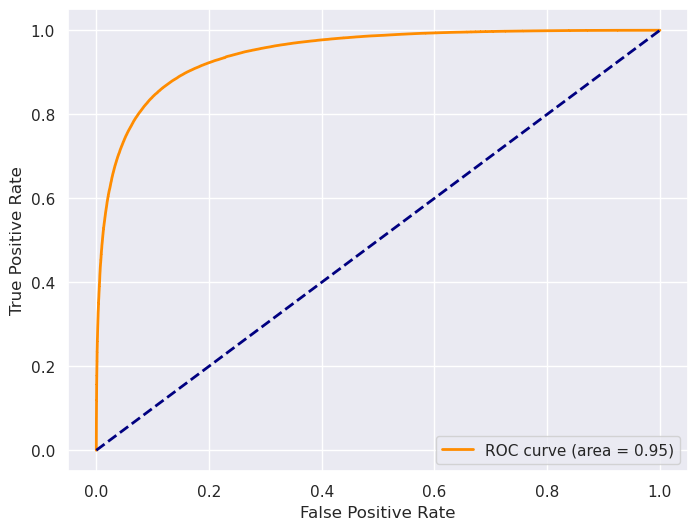

In [ ]:
# ROC-AUC Score and Curve
roc_auc = roc_auc_score(true_labels, predictions[:, 1])
fpr, tpr, _ = roc_curve(true_labels, predictions[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

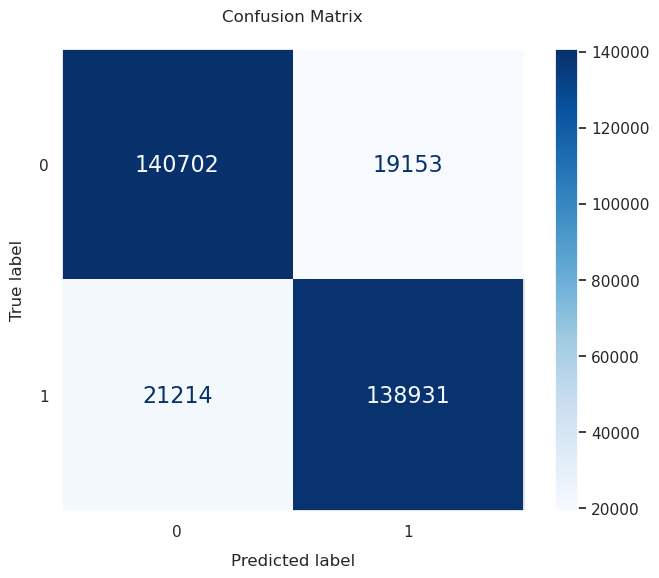

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 6))


ax.set_title('Confusion Matrix', pad=20)  
ax.set_xlabel('Predicted Label', labelpad=10)  
ax.set_ylabel('True Label', labelpad=10)
ax.grid(False)
disp.plot(cmap='Blues', ax=ax, colorbar=True)
plt.show()


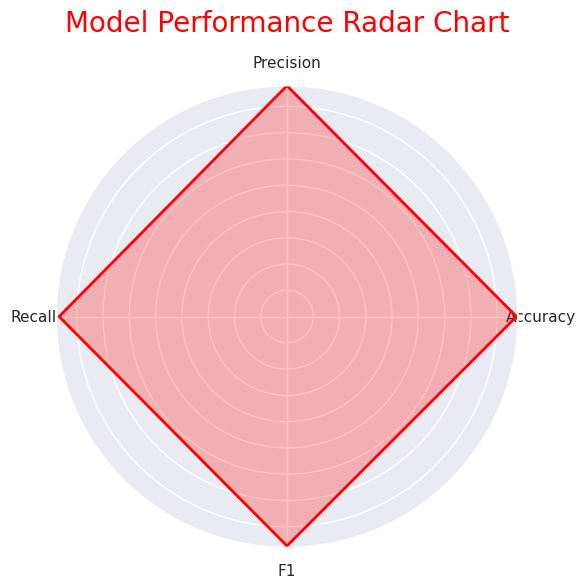

In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')
conf_mat = confusion_matrix(true_labels, predicted_labels)

labels=np.array(['Accuracy', 'Precision', 'Recall', 'F1'])
stats=np.array([accuracy, precision, recall, f1])

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
stats=np.concatenate((stats,[stats[0]]))
angles+=angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, stats, color='red', alpha=0.25)
ax.plot(angles, stats, color='red', linewidth=2)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

plt.title('Model Performance Radar Chart', size=20, color='red', y=1.1)
plt.show()


In [ ]:
count = 0
for ind, num in enumerate(predicted_labels):
    if num != true_labels[ind]:
        print('Tweet: ', text[ind])
        print('Predicted Sentiment: ', predicted_labels[ind])
        print('Actual Sentiment: ', true_labels[ind])
        count += 1
        if count == 5:
            break

Tweet:  entity ahh ive always wanted to see rent  love the soundtrack!!
Predicted Sentiment:  0
Actual Sentiment:  1
Tweet:  thought sleeping in was an option tomorrow but realizing that it now is not. evaluations in the morning and work in the afternoon!
Predicted Sentiment:  1
Actual Sentiment:  0
Tweet:  really don't feel like getting up today... but got to study to for tomorrows practical exam...
Predicted Sentiment:  0
Actual Sentiment:  1
Tweet:  ugh....92 degrees tomorrow
Predicted Sentiment:  0
Actual Sentiment:  1
Tweet:  where did u move to?  i thought u were already in sd. ?? hmmm. random u found me. glad to hear yer doing well.
Predicted Sentiment:  1
Actual Sentiment:  0


In [ ]:
for i in range(5):
    print('Tweet: ', text[i])
    print('Predicted Sentiment: ', predicted_labels[i])
    print('Actual Sentiment: ', true_labels[i])
    print()

Tweet:  entity  - awww, that's a bummer.  you shoulda got david carr of third day to do it. ;d
Predicted Sentiment:  0
Actual Sentiment:  0

Tweet:  is upset that he can't update his facebook by texting it... and might cry as a result  school today also. blah!
Predicted Sentiment:  0
Actual Sentiment:  0

Tweet:  entity i dived many times for the ball. managed to save 50%  the rest go out of bounds
Predicted Sentiment:  1
Actual Sentiment:  1

Tweet:  my whole body feels itchy and like its on fire
Predicted Sentiment:  1
Actual Sentiment:  1

Tweet:  entity no, it's not behaving at all. i'm mad. why am i here? because i can't see you all over there.
Predicted Sentiment:  0
Actual Sentiment:  0



In [ ]:
from transformers import BertTokenizer,BertForSequenceClassification
import torch
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
output_dir = './'
tokenizer = BertTokenizer.from_pretrained(output_dir)
model_loaded = BertForSequenceClassification.from_pretrained(output_dir)

Loading BERT tokenizer...


In [ ]:
def Sentiment(sent):
    output_dir = './'
    tokenizer = BertTokenizer.from_pretrained(output_dir)
    model_loaded = BertForSequenceClassification.from_pretrained(output_dir)
    encoded_dict = tokenizer.encode_plus(
                        sent, 
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
        
    input_id = encoded_dict['input_ids']

    attention_mask = encoded_dict['attention_mask']
    input_id = torch.LongTensor(input_id)
    attention_mask = torch.LongTensor(attention_mask)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_loaded = model_loaded.to(device)
    input_id = input_id.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model_loaded(input_id, token_type_ids=None, attention_mask=attention_mask)

    logits = outputs[0]
    index = logits.argmax()
    return index

In [ ]:
ans = Sentiment('i want to die')

if ans == 1:
    print("Positive")
else:
    print("Negative")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Negative


In [ ]:
ans = Sentiment('i have never been happier')

if ans == 1:
    print("Positive")
else:
    print("Negative")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Positive
